This is needed to reload modules without restarting the kernel

In [3]:
%load_ext autoreload
%autoreload 2

This is needed to add eda_tools from the directories above

In [4]:
import os
os.sys.path.append('../../')


Base Packages

In [5]:
import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

Base plotting style

In [6]:
import mplhep as hep
hep.set_style('ATLAS')

# Optimize the binning in the background prediction

Introduction

In [7]:
!ls -lh /mnt/storage/lborgna/NNT/cryptotuples-MAY21/data/data_baseline_bl_*_with_weights.root

-rw-r--r-- 1 lborgna users 663M May 25 13:37 /mnt/storage/lborgna/NNT/cryptotuples-MAY21/data/data_baseline_bl_16_with_weights.root
-rw-r--r-- 1 lborgna users 607M May 25 13:37 /mnt/storage/lborgna/NNT/cryptotuples-MAY21/data/data_baseline_bl_17_with_weights.root
-rw-r--r-- 1 lborgna users 1.4G May 25 13:39 /mnt/storage/lborgna/NNT/cryptotuples-MAY21/data/data_baseline_bl_18_with_weights.root


In [8]:
from hh4b_utils.nnt_tools import load_nnt, get_mu, get_mu_iqr

In [11]:
dfs = {}

for year in ["16", "17", "18"]:
    fp = f"/mnt/storage/lborgna/NNT/cryptotuples-MAY21/data/data_baseline_bl_{year}_with_weights.root"
    dfs[year] = load_nnt(fp, trees=["control", "validation", "sig"])
    f = uproot.open(fp)
    dfs[f"mu_{year}"] = get_mu(f, year)
    dfs[f"mu_vr_{year}"] = get_mu(f, year, vr=True)
    dfs[f"mu_iqr_{year}"] = get_mu_iqr(f, year)
    dfs[f"mu_iqr_vr_{year}"] = get_mu_iqr(f, year, vr=True)
    dfs[year]["NN_weight"] = dfs[f"mu_{year}"] * dfs[year][f"NN_d24_weight_bstrap_med_{year}"]

100%|██████████| 11/11 [00:13<00:00,  1.25s/it]


In [12]:
list_of_df = []
for year in ['16','17','18']:
    _df = dfs[year]
    _df['year'] = year
    list_of_df.append(_df)

In [13]:
df = pd.concat(list_of_df, ignore_index=True)

### all the data is loading into one dataframe for convenience

**generate 1 GeV bins from 200 to 1250**

In [314]:
be = np.arange(200, 1251, )

In [15]:
be = np.linspace(200, 1250, 101)

In [315]:
be.shape

(1051,)

In [17]:
mask_2b = df['ntag']==2
mask_sr = df['kinematic_region']==0
mask_rw4b = df['rw_to_4b']
mask = mask_2b & mask_sr & mask_rw4b

**Generate the histogram**

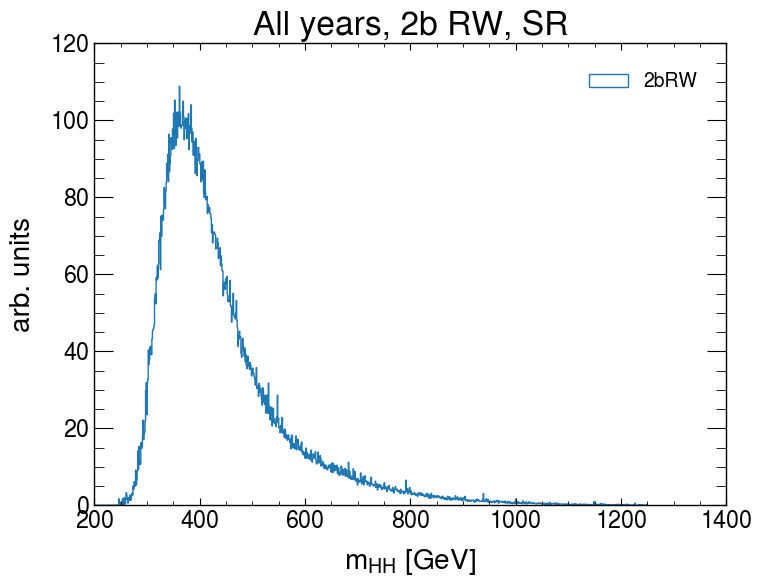

In [316]:
h, be_new, _ = plt.hist(
    df.loc[mask, "m_hh"].values,
    bins=be,
    histtype="step",
    weights=df.loc[mask, "NN_weight"],
    label = '2bRW'
)
plt.xlabel("$m_{HH}$ [GeV]")
plt.ylabel("arb. units")
plt.title("All years, 2b RW, SR")
plt.legend()

**Function testing**

In [20]:
h[h>50].shape

(45,)

In [21]:
h.shape

(100,)

In [22]:
be.shape

(101,)

In [23]:
be[h>50]

IndexError: boolean index did not match indexed array along dimension 0; dimension is 101 but corresponding boolean dimension is 100

In [24]:
h_t = np.array([1, 3, 5, 1, 2, 1])
be_t = np.array([100, 200, 300, 400, 500, 600, 700])

In [25]:
new_bins = be_t[1:][h_t>1]

In [26]:
new_bins 

array([300, 400, 600])

In [27]:
first_bin = be_t[0]
last_bin = be_t[-1]

In [28]:
first_and_last_bin = np.array([be_t[0], be_t[-1]])

In [29]:
new_bins2 = np.append(new_bins, first_and_last_bin)

In [30]:
new_bins2.sort()

In [31]:
new_bins2

array([100, 300, 400, 600, 700])

[StepArtists(step=<matplotlib.lines.Line2D object at 0x7f74c87335f8>, errorbar=None, legend_artist=None)]

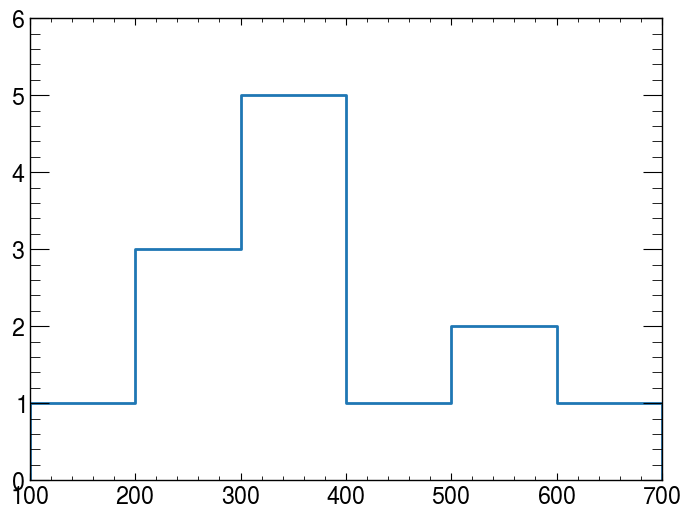

In [32]:
hep.histplot(h_t, be_t)

[StepArtists(step=<matplotlib.lines.Line2D object at 0x7f74c8bdd390>, errorbar=None, legend_artist=None)]

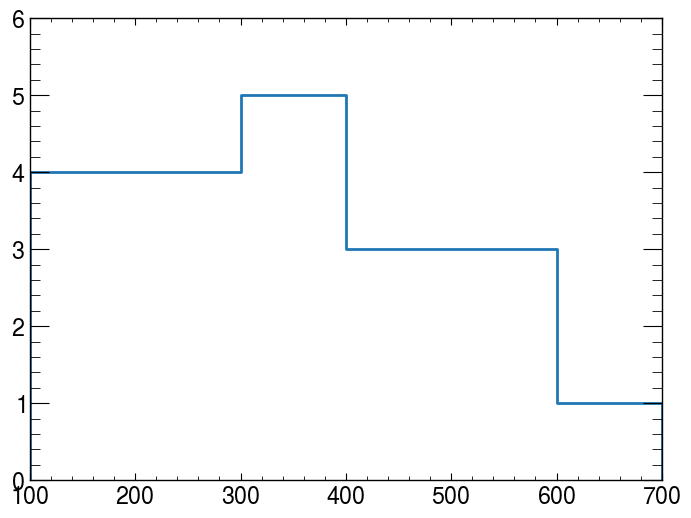

In [33]:
hep.histplot([4, 5, 3, 1], new_bins2)

**Formalized adaptive binning function**

In [34]:
def adaptive_binning(hist, bin_edges, threshold):
    """
    This function will provide new bin edges that can be used to 
    rebin a histogram such that all of its entries are above the threshold
    
    """
    new_bins = bin_edges[1:][hist>threshold]
    first_and_last_bin = np.array([bin_edges[0], bin_edges[-1]])
    new_bins2 = np.append(new_bins, first_and_last_bin)
    new_bins2.sort()
    return new_bins2

In [35]:
be_new

array([ 200. ,  210.5,  221. ,  231.5,  242. ,  252.5,  263. ,  273.5,
        284. ,  294.5,  305. ,  315.5,  326. ,  336.5,  347. ,  357.5,
        368. ,  378.5,  389. ,  399.5,  410. ,  420.5,  431. ,  441.5,
        452. ,  462.5,  473. ,  483.5,  494. ,  504.5,  515. ,  525.5,
        536. ,  546.5,  557. ,  567.5,  578. ,  588.5,  599. ,  609.5,
        620. ,  630.5,  641. ,  651.5,  662. ,  672.5,  683. ,  693.5,
        704. ,  714.5,  725. ,  735.5,  746. ,  756.5,  767. ,  777.5,
        788. ,  798.5,  809. ,  819.5,  830. ,  840.5,  851. ,  861.5,
        872. ,  882.5,  893. ,  903.5,  914. ,  924.5,  935. ,  945.5,
        956. ,  966.5,  977. ,  987.5,  998. , 1008.5, 1019. , 1029.5,
       1040. , 1050.5, 1061. , 1071.5, 1082. , 1092.5, 1103. , 1113.5,
       1124. , 1134.5, 1145. , 1155.5, 1166. , 1176.5, 1187. , 1197.5,
       1208. , 1218.5, 1229. , 1239.5, 1250. ])

In [36]:
new_bins2 = adaptive_binning(h, be_new, threshold = 50)

In [37]:
new_bins2

array([ 200. ,  284. ,  294.5,  305. ,  315.5,  326. ,  336.5,  347. ,
        357.5,  368. ,  378.5,  389. ,  399.5,  410. ,  420.5,  431. ,
        441.5,  452. ,  462.5,  473. ,  483.5,  494. ,  504.5,  515. ,
        525.5,  536. ,  546.5,  557. ,  567.5,  578. ,  588.5,  599. ,
        609.5,  620. ,  630.5,  641. ,  651.5,  662. ,  672.5,  683. ,
        693.5,  704. ,  714.5,  725. ,  735.5,  746. , 1250. ])

**plot the old histogram with new bins**

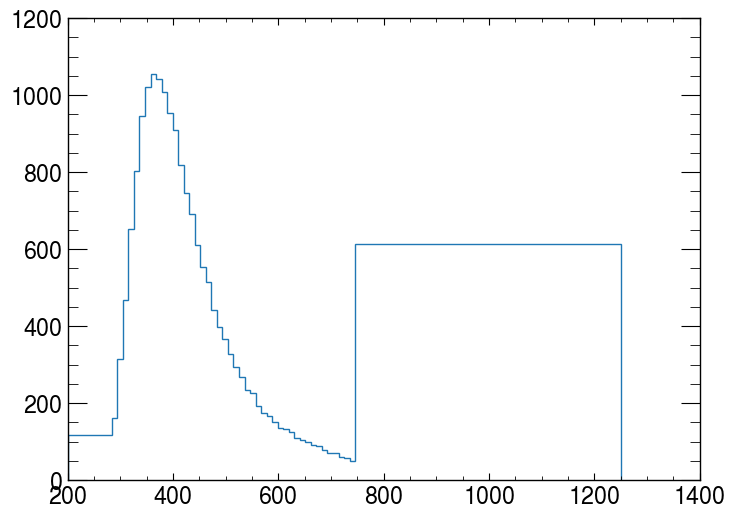

In [39]:
h_rebbined, new_bins2, _ = plt.hist(df.loc[mask,'m_hh'].values, bins = new_bins2, histtype='step', weights = df.loc[mask,'NN_weight'])


looks funky eh? lets divide by the bin-width

In [41]:
h_rebinned_bw = h_rebbined / (new_bins2[1:] - new_bins2[:-1])

In [42]:
h_rebinned_bw

array([  1.38279569,  15.28493585,  30.02640588,  44.62807562,
        62.0427355 ,  76.56495696,  90.10096627,  97.25095803,
       100.418876  ,  99.2383023 ,  96.03010274,  90.92418313,
        86.60348146,  77.93810641,  70.94515358,  65.89254273,
        58.0965709 ,  52.66497691,  49.02439717,  42.10657686,
        37.76788213,  34.9071755 ,  31.29163412,  28.09773963,
        25.49281647,  22.23261222,  21.53586197,  18.4477797 ,
        16.69599921,  15.87147926,  14.42738544,  12.8601346 ,
        12.62311339,  11.80657531,  10.30656286,   9.94649616,
         9.52565915,   8.66235072,   8.55015509,   7.51195812,
         6.60771179,   6.67677069,   5.74483368,   5.53043588,
         4.7765252 ,   1.21825939])

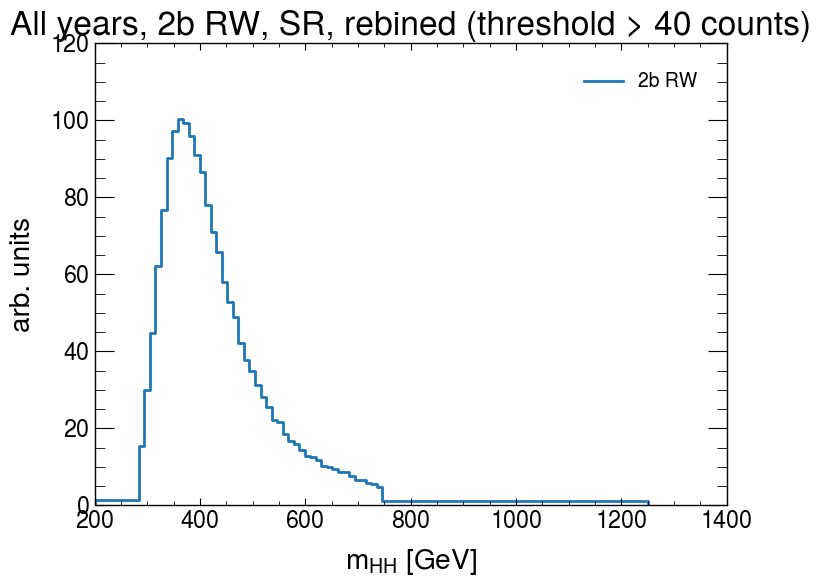

In [43]:
hep.histplot(h_rebinned_bw, new_bins2, histtype='step', label = '2b RW')
plt.xlabel("$m_{HH}$ [GeV]")
plt.ylabel("arb. units")
plt.title("All years, 2b RW, SR, rebined (threshold > 40 counts)")
plt.legend()

**so this is just takin out all the bins with lower than the treshold value hence why you end up with such a large bins**

In [45]:
h.shape

(100,)

In [46]:
be.shape

(101,)

In [234]:
h_t = np.array([0, 0, 3, 5, 1, 1, 1])
be_t = np.array([0,100, 200, 300, 400, 500, 600, 700])

In [235]:
h_t.shape[0]

7

In [236]:
def adaptive_binning2(hist, bin_edges, threshold):
    """
    This function will provide new bin edges that can be used to 
    rebin a histogram such that all of its entries are above the threshold
    
    """
    _hist = hist.copy()
    _be = bin_edges.copy()
    
    nhist = _hist.shape[0]
    bins_to_delete = []
    hist_to_delete = []
    
    for i, _ in enumerate(_hist):
        is_last_bin = (i == (nhist-1))

        if (_hist[i] <= threshold) & (not is_last_bin):
            print(i,_hist[i], '1', f'be_del: {i+1}', f'hist_del: {i}')
            _hist[i+1] = _hist[i+1] + _hist[i]
            
            bins_to_delete.append(i+1)
            hist_to_delete.append(i)
        elif (_hist[i]<=threshold) & is_last_bin:
            print(i,_hist[i], '2',f'be_del: {i}', f'hist_del: {i}')
            _hist[i-1] = _hist[i-1] + _hist[i]
        
            bins_to_delete.append(i)
            hist_to_delete.append(i)
        else:
            print(i, _hist[i])
        
    
    
    _hist = np.delete(_hist, hist_to_delete)
    _be = np.delete(_be, bins_to_delete)
    #print(len(hist_to_delete))
    #print(len(bins_to_delete))
    
    return _hist, _be

In [267]:
for i in reversed(range(5)):
    print(i)

4
3
2
1
0


In [313]:
def adaptive_binning(hist:np.array, bin_edges:np.array, threshold:float):
    """
    This function will rebin a histogram such that no entry has lower values
    than the threshold provided. 
    It will return the new histogram counts along with its bin edges.
    
    """
    _hist = hist.copy()
    _be = bin_edges.copy()
    
    nhist = _hist.shape[0]
    bins_to_delete = []
    hist_to_delete = []
    
    #Forward pass
    for i, _ in enumerate(_hist):
        is_last_bin = (i == (nhist-1))

        if (_hist[i] <= threshold) & (not is_last_bin):
            print(i,_hist[i], '1', f'be_del: {i+1}', f'hist_del: {i}')
            _hist[i+1] = _hist[i+1] + _hist[i]
            
            bins_to_delete.append(i+1)
            hist_to_delete.append(i)

    _hist = np.delete(_hist, hist_to_delete)
    _be = np.delete(_be, bins_to_delete)
    
    hist_to_delete = []
    bins_to_delete = []
    #Backward reverse pass
    for i, _ in reversed(list(enumerate(_hist))):
        is_first_bin = (i == 0)
        
        if (_hist[i] <= threshold) & (not is_first_bin):
            _hist[i-1] = _hist[i-1] + _hist[i]
            hist_to_delete.append(i)
            bins_to_delete.append(i)
            
    _hist = np.delete(_hist, hist_to_delete)
    _be = np.delete(_be, bins_to_delete)
    
    return _hist, _be

In [282]:
_hist, _be = adaptive_binning2(h_t, be_t, 1)

0 0 1 be_del: 1 hist_del: 0
1 0 1 be_del: 2 hist_del: 1
2 3
3 5
4 1 1 be_del: 5 hist_del: 4
5 2
6 1 2 be_del: 6 hist_del: 6


In [283]:
_hist

array([3, 5, 3])

In [284]:
_be

array([  0, 300, 400, 700])

In [285]:
_hist.shape

(3,)

In [286]:
_be.shape

(4,)

**Gaussian Test**

In [287]:
x = np.random.normal(0, 1, 100000)

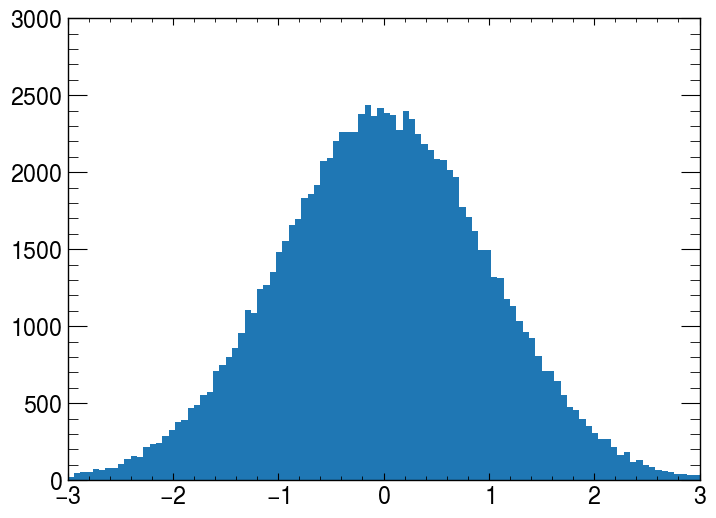

In [296]:
h_g, be_g, _ = plt.hist(x, bins = 100, range=(-3,3))

In [297]:
h_g.T, be_g.T

(array([  19.,   47.,   54.,   54.,   74.,   67.,   76.,   81.,  108.,
         139.,  157.,  152.,  212.,  233.,  243.,  289.,  326.,  377.,
         391.,  469.,  489.,  556.,  574.,  708.,  749.,  800.,  858.,
         957., 1105., 1084., 1243., 1270., 1350., 1482., 1552., 1655.,
        1694., 1833., 1855., 1914., 2075., 2093., 2199., 2260., 2262.,
        2260., 2377., 2436., 2364., 2415., 2386., 2373., 2276., 2399.,
        2344., 2249., 2182., 2142., 2086., 2078., 2012., 1967., 1771.,
        1706., 1617., 1497., 1494., 1322., 1310., 1175., 1134., 1033.,
         964.,  922.,  803.,  706.,  710.,  641.,  554.,  475.,  455.,
         396.,  352.,  308.,  269.,  266.,  214.,  163.,  180.,  116.,
         131.,   99.,   87.,   65.,   57.,   56.,   37.,   39.,   32.,
          31.]),
 array([-3.  , -2.94, -2.88, -2.82, -2.76, -2.7 , -2.64, -2.58, -2.52,
        -2.46, -2.4 , -2.34, -2.28, -2.22, -2.16, -2.1 , -2.04, -1.98,
        -1.92, -1.86, -1.8 , -1.74, -1.68, -1.62, -1.56, -1.

In [298]:
bw = be_g[0]-be_g[1]

In [299]:
bw

-0.06000000000000005

In [300]:
h_g2, be_g2 = adaptive_binning3(h_g, be_g, threshold=1999)

0 19.0 1 be_del: 1 hist_del: 0
1 66.0 1 be_del: 2 hist_del: 1
2 120.0 1 be_del: 3 hist_del: 2
3 174.0 1 be_del: 4 hist_del: 3
4 248.0 1 be_del: 5 hist_del: 4
5 315.0 1 be_del: 6 hist_del: 5
6 391.0 1 be_del: 7 hist_del: 6
7 472.0 1 be_del: 8 hist_del: 7
8 580.0 1 be_del: 9 hist_del: 8
9 719.0 1 be_del: 10 hist_del: 9
10 876.0 1 be_del: 11 hist_del: 10
11 1028.0 1 be_del: 12 hist_del: 11
12 1240.0 1 be_del: 13 hist_del: 12
13 1473.0 1 be_del: 14 hist_del: 13
14 1716.0 1 be_del: 15 hist_del: 14
16 326.0 1 be_del: 17 hist_del: 16
17 703.0 1 be_del: 18 hist_del: 17
18 1094.0 1 be_del: 19 hist_del: 18
19 1563.0 1 be_del: 20 hist_del: 19
21 556.0 1 be_del: 22 hist_del: 21
22 1130.0 1 be_del: 23 hist_del: 22
23 1838.0 1 be_del: 24 hist_del: 23
25 800.0 1 be_del: 26 hist_del: 25
26 1658.0 1 be_del: 27 hist_del: 26
28 1105.0 1 be_del: 29 hist_del: 28
30 1243.0 1 be_del: 31 hist_del: 30
32 1350.0 1 be_del: 33 hist_del: 32
34 1552.0 1 be_del: 35 hist_del: 34
36 1694.0 1 be_del: 37 hist_del: 36
38

In [301]:
h_g2.shape

(40,)

In [302]:
be_g2.shape

(41,)

Text(0, 0.5, 'Events')

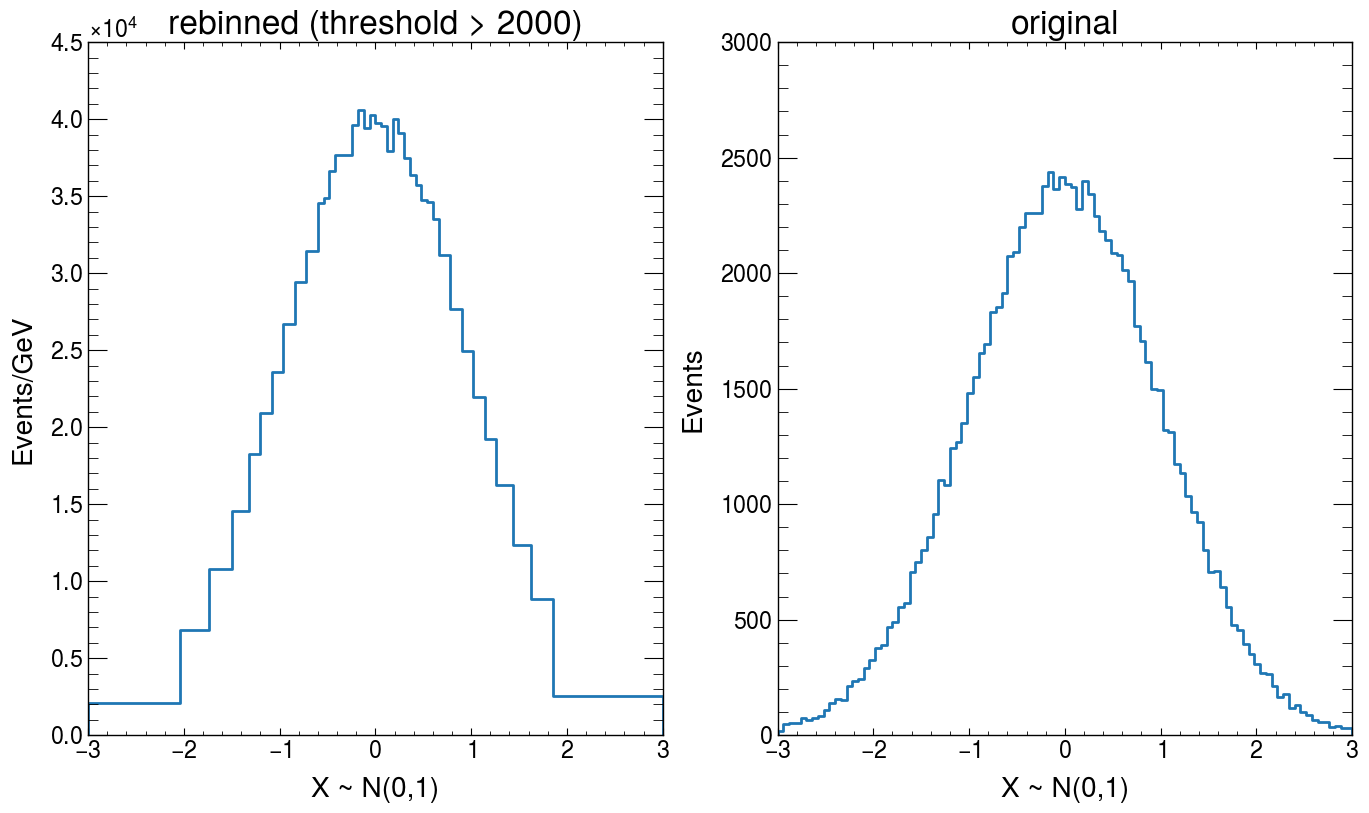

In [312]:
f, ax = plt.subplots(1, 2,figsize=(16,9))
hep.histplot(
    h_g2 / (be_g2[1:] - be_g2[:-1]),
    be_g2,
    histtype="step",
    label="rebinned",
    ax=ax[0]
)
hep.histplot(h_g, be_g, histtype="step", label="initial", ax=ax[1])
ax[0].set_title('rebinned (threshold > 2000)')
ax[1].set_title('original')
ax[0].set_xlabel('X ~ N(0,1)')
ax[1].set_xlabel('X ~ N(0,1)')
ax[0].set_ylabel('Events/GeV')
ax[1].set_ylabel('Events')

In [333]:
h_new2, new_bins2 = adaptive_binning(h, be_new, threshold = 100)

0 0.0 1 be_del: 1 hist_del: 0
1 0.0 1 be_del: 2 hist_del: 1
2 0.0 1 be_del: 3 hist_del: 2
3 0.0 1 be_del: 4 hist_del: 3
4 0.0 1 be_del: 5 hist_del: 4
5 0.0 1 be_del: 6 hist_del: 5
6 0.0 1 be_del: 7 hist_del: 6
7 0.0 1 be_del: 8 hist_del: 7
8 0.0 1 be_del: 9 hist_del: 8
9 0.0 1 be_del: 10 hist_del: 9
10 0.0 1 be_del: 11 hist_del: 10
11 0.0 1 be_del: 12 hist_del: 11
12 0.0 1 be_del: 13 hist_del: 12
13 0.0 1 be_del: 14 hist_del: 13
14 0.0 1 be_del: 15 hist_del: 14
15 0.0 1 be_del: 16 hist_del: 15
16 0.0 1 be_del: 17 hist_del: 16
17 0.0 1 be_del: 18 hist_del: 17
18 0.0 1 be_del: 19 hist_del: 18
19 0.0 1 be_del: 20 hist_del: 19
20 0.0 1 be_del: 21 hist_del: 20
21 0.0 1 be_del: 22 hist_del: 21
22 0.0 1 be_del: 23 hist_del: 22
23 0.0 1 be_del: 24 hist_del: 23
24 0.0 1 be_del: 25 hist_del: 24
25 0.0 1 be_del: 26 hist_del: 25
26 0.0 1 be_del: 27 hist_del: 26
27 0.0 1 be_del: 28 hist_del: 27
28 0.0 1 be_del: 29 hist_del: 28
29 0.0 1 be_del: 30 hist_del: 29
30 0.0 1 be_del: 31 hist_del: 30
31 0.0

623 28.767869099370728 1 be_del: 624 hist_del: 623
624 31.497970797066955 1 be_del: 625 hist_del: 624
625 33.9673171798604 1 be_del: 626 hist_del: 625
626 36.386046914693 1 be_del: 627 hist_del: 626
627 38.57557617770726 1 be_del: 628 hist_del: 627
628 41.2969702342416 1 be_del: 629 hist_del: 628
629 43.53403319244535 1 be_del: 630 hist_del: 629
630 45.87456839780498 1 be_del: 631 hist_del: 630
631 48.98289900265081 1 be_del: 632 hist_del: 631
632 51.991636216636834 1 be_del: 633 hist_del: 632
633 54.43940753554125 1 be_del: 634 hist_del: 633
634 56.31262672692537 1 be_del: 635 hist_del: 634
635 59.025801464573306 1 be_del: 636 hist_del: 635
636 60.95751924689466 1 be_del: 637 hist_del: 636
637 63.39864252736879 1 be_del: 638 hist_del: 637
638 65.18940038941219 1 be_del: 639 hist_del: 638
639 68.28822058093647 1 be_del: 640 hist_del: 639
640 70.85270948585821 1 be_del: 641 hist_del: 640
641 73.29607080499409 1 be_del: 642 hist_del: 641
642 75.7921777546726 1 be_del: 643 hist_del: 642
6

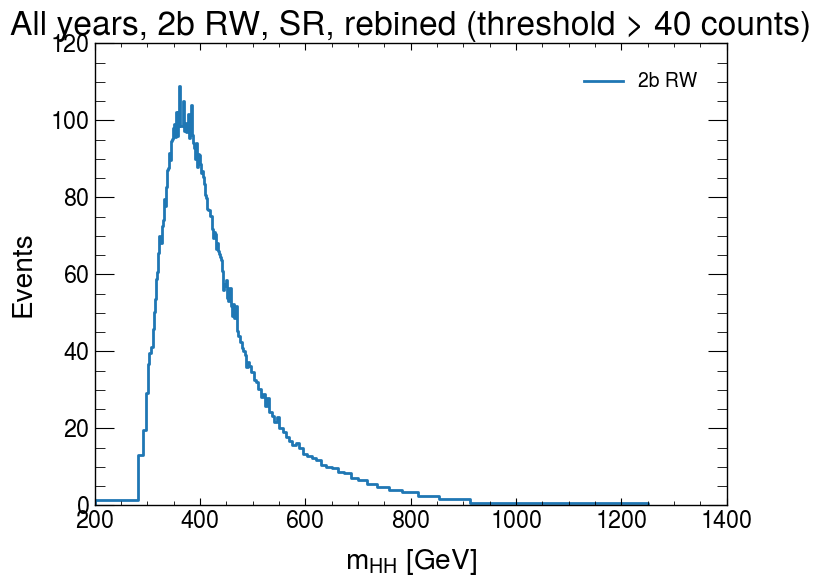

In [334]:
hep.histplot(h_new2/(new_bins2[1:]-new_bins2[:-1]), new_bins2, histtype='step', label = '2b RW')
plt.xlabel("$m_{HH}$ [GeV]")
plt.ylabel("Events")
plt.title("All years, 2b RW, SR, rebined (threshold > 40 counts)")
plt.legend()

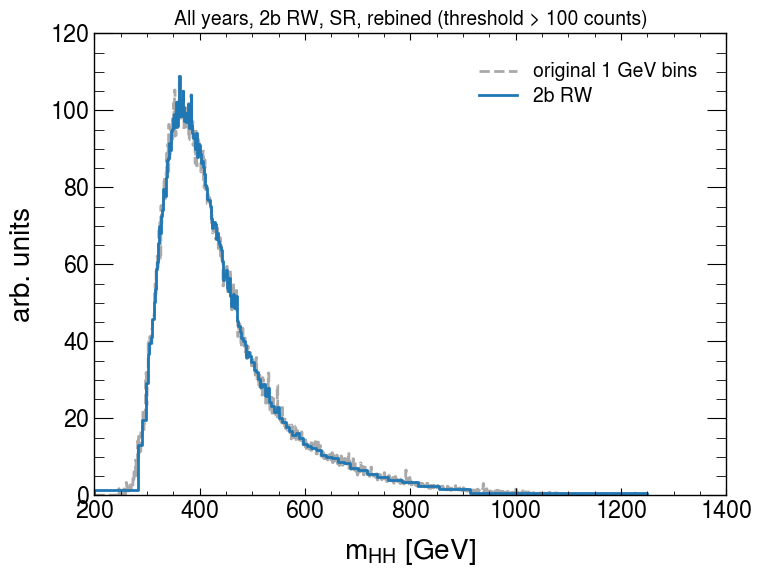

In [337]:
hep.histplot(h,be, label = 'original 1 GeV bins', ls='--', color ='darkgrey')
hep.histplot(h_new2/(new_bins2[1:]-new_bins2[:-1]), new_bins2, histtype='step', label = '2b RW')
plt.xlabel("$m_{HH}$ [GeV]")
plt.ylabel("arb. units")
plt.title("All years, 2b RW, SR, rebined (threshold > 100 counts)", fontsize =14)
plt.legend()